# Model calibration via MCMC sampling

This notebook implements Metropolis-Hastings MCMC to infer posterior distributions of wall decay coefficients in the Bristol Water Field Lab. It employs a GP surrogate model in place of the (expensive) EPANET water quality simulator (see `04-GP_surrogate_modelling.ipynb`) and field data organized in `01-data-period-features.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import joblib
from scipy.stats import truncnorm, triang, uniform, norm
from tqdm.notebook import tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from bayesian_wq_calibration.constants import TIMESERIES_DIR, RESULTS_DIR
# from bayesian_wq_calibration.calibration import

### Load data

Load operational data for selected sensing period.

In [2]:
data_period = 18 # 20 calibration events (as at 30 October 2024)
wq_sensors_used = 'kiosk only' # 'kiosk only', 'kiosk + hydrant'
demand_resolution = 'wwmd' # 'dma', 'wwmd'

try:
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
    
except FileNotFoundError:
    print(f"Data period {data_period} does not exist.")

Set modelling parameters.

In [3]:
sim_days = 5  # must match number of days used to train GP model
time_steps = sim_days * 24 * 4
datetime_vals = cl_df['datetime'].unique()
datetime_subset = datetime_vals[:time_steps]
cl_df = cl_df[cl_df['datetime'].isin(datetime_subset)]

wq_sensors_used = 'kiosk only' # 'kiosk only', 'kiosk + hydrant'
source_ids = ['BW1', 'BW4']
kiosk_ids = ['BW1', 'BW2', 'BW4', 'BW5', 'BW9', 'BW12']
if wq_sensors_used == 'kiosk only':
    cl_df = cl_df[(cl_df['bwfl_id'].isin(kiosk_ids)) & (~cl_df['bwfl_id'].isin(source_ids))]
else:
    cl_df = cl_df[~cl_df['bwfl_id'].isin(source_ids)]
sensor_names = cl_df['bwfl_id'].unique()
demand_resolution = 'wwmd' # 'dma', 'wwmd'

Wall decay grouping.

In [4]:
# see notebook `02-pipe-grouping-exploration.ipynb` for details on pipe groups
grouping = 'material-age-velocity'

# load ga results to get param_mean data
ga_results_df = pd.read_excel(RESULTS_DIR / 'wq/ga_calibration.xlsx', sheet_name=grouping)
ga_results_df = ga_results_df[(ga_results_df['data_period'] == data_period) & (ga_results_df['demand_resolution'] == demand_resolution) & (ga_results_df['wq_sensors_used'] == wq_sensors_used)]
ga_results = ga_results_df[[col for col in ga_results_df.columns if col.startswith('G')]].values[0]

grouping_data = {
    'single': {
        'param_group': ['G0'],
        'param_bounds': [(-0.5, 0.0)],
        'param_mean': ga_results
    },
    'material-only': {
        'param_group': ['G0', 'G1'],
        'param_bounds': [(-1.0, -0.01), (-0.5, -0.01), (-0.15, -0.01)],
        'param_mean': ga_results
    },
    'material-age-diameter': {
        'param_group': ['G0', 'G1', 'G2', 'G3', 'G4', 'G5'],
        'param_bounds': [(-1.0, -0.01), (-1.0, -0.01), (-0.5, -0.01), (-0.5, -0.01), (-0.2, -0.01)],
        'param_mean': ga_results
    },
    'material-age-velocity': {
        'param_group': ['G0', 'G1', 'G2', 'G3', 'G4', 'G5'],
        'param_bounds': [(-1.0, -0.01), (-1.0, -0.01), (-0.5, -0.01), (-0.5, -0.01), (-0.2, -0.01)],
        'param_mean': ga_results
    }
}

param_data = grouping_data[grouping]
param_group = param_data['param_group']
param_bounds = param_data['param_bounds']
param_mean = param_data['param_mean']

### Run Metropolis-Hastings MCMC algorithm

Enter text here...

In [40]:
def create_mcmc_plot(samples, current_step, accepted_steps):
    """Create MCMC trace and density plot"""
    current_samples = samples[:current_step + 1]
    
    fig = make_subplots(cols=2, 
                       column_widths=[0.3, 0.7],
                       subplot_titles=['Density', 'MCMC Trace'])
    
    # density plot (left panel, rotated)
    fig.add_trace(
        go.Histogram(y=current_samples,
                    orientation='h',
                    marker_color='rgb(128, 128, 128)',
                    showlegend=False),
        col=1, row=1
    )
    
    # MCMC trace (right panel)
    fig.add_trace(
        go.Scatter(y=current_samples,
                  x=np.arange(len(current_samples)),
                  mode='lines',
                  line=dict(color='rgb(128, 128, 128)', width=1),
                  showlegend=False),
        col=2, row=1
    )
    
    # add accepted/rejected points
    for i, accepted in enumerate(accepted_steps):
        if i <= current_step:
            fig.add_trace(
                go.Scatter(x=[i],
                          y=[current_samples[i]],
                          mode='markers',
                          marker=dict(
                              color='rgb(0, 255, 0)' if accepted else 'rgb(255, 0, 0)',
                              size=6
                          ),
                          showlegend=False),
                col=2, row=1
            )
            
    fig.update_layout(
        height=300,
        width=1200,
        showlegend=False,
        template='plotly_white'
    )
    fig.update_xaxes(title_text='Density', col=1, row=1)
    fig.update_xaxes(title_text='MCMC Iteration', col=2, row=1)
    fig.update_yaxes(title_text='θ', col=1, row=1)
    fig.update_yaxes(title_text='θ', col=2, row=1)
    
    return fig


def load_gp_models(sensor_names, demand_resolution, sim_days):
    """Load saved GP models"""
    model_dir = RESULTS_DIR / 'wq/gp_models'
    model_dir.mkdir(parents=True, exist_ok=True)
    gp_models = {}
    
    for sensor in sensor_names:
        filename = f'gp_{sensor}_{demand_resolution}_{sim_days}-day_sim.joblib'
        model_path = model_dir / filename
        gp_models[sensor] = joblib.load(model_path)
    
    return gp_models


def propose_next_parameter(current_param, dist_type, rel_uncertainty, param_bounds):
    """
    Propose next parameter value using current value as distribution center
    
    Args:
        current_param: current accepted parameter value (used as distribution mean)
        dist_type: type of proposal distribution
        rel_uncertainty: relative uncertainty for computing sigma
        param_bounds: original (lower, upper) bounds for the parameter
    """
    sigma = abs(current_param * rel_uncertainty)
    current_lb = current_param - 3*sigma
    current_ub = current_param + 3*sigma
    effective_lb = max(param_bounds[0], current_lb)
    effective_ub = min(param_bounds[1], current_ub)
    
    sample = np.random.random()  
    if dist_type == 'truncated normal':
        a = (effective_lb - current_param) / sigma
        b = (effective_ub - current_param) / sigma
        return truncnorm.ppf(sample, a=a, b=b, loc=current_param, scale=sigma)
        
    elif dist_type == 'triangle':
        c = (current_param - effective_lb) / (effective_ub - effective_lb)
        return triang.ppf(sample, c=c, loc=effective_lb, scale=effective_ub - effective_lb)
        
    elif dist_type == 'uniform':
        return uniform.ppf(sample, loc=effective_lb, scale=effective_ub - effective_lb)
    
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")


def log_likelihood(theta, gp_models, cl_df, noise_std=0.1):
    """
    Calculate log likelihood using scaled parameters
    
    Args:
        theta: array of wall decay parameters to evaluate
        gp_models: dictionary of GP models keyed by sensor name
        cl_df: DataFrame containing measured chlorine data with columns:
               'bwfl_id' (sensor identifier) and 'mean' (chlorine measurements)
        noise_std: observation noise standard deviation
        
    Returns:
        float: total log likelihood summed across all sensors
        
    Notes:
        - Parameters are scaled using each GP model's stored scaler
        - Only matches time steps where both simulated and measured data exist
        - Excludes first day (96 time steps) for initialization period
    """
    total_ll = 0
    
    for sensor_name in gp_models:
        theta_scaled = gp_models[sensor_name]['scaler'].transform(theta.reshape(1, -1))
        sim_cl = gp_models[sensor_name]['gp_model'].predict(theta_scaled).T.ravel()
        data_cl = cl_df.loc[cl_df['bwfl_id'] == sensor_name, 'mean'].values
        mask = ~np.isnan(sim_cl) & ~np.isnan(data_cl) & (np.arange(len(sim_cl)) >= 96)
        total_ll += norm.logpdf(data_cl[mask], loc=sim_cl[mask], scale=noise_std).sum()
    
    return total_ll

    
def run_mcmc(gp_models, cl_df, prior_params, n_iter=10000, noise_std=0.1, burn_in=500):
    """
    Run MCMC sampling with visualization
    
    Args:
        gp_models: dictionary of GP models keyed by sensor name
        cl_df: DataFrame containing measured chlorine data with columns:
               'bwfl_id' (sensor identifier) and 'mean' (chlorine measurements)
        prior_params: list of dictionaries containing prior distribution parameters
        n_iter: number of MCMC iterations
        noise_std: observation noise standard deviation for likelihood calculation
    
    Returns:
        tuple: (samples array of shape (n_iter, n_params), 
                log_likelihoods array of shape (n_iter,))
    """
    # initialize storage
    n_params = len(prior_params)
    samples = np.zeros((n_iter, n_params))
    log_likelihoods = np.zeros(n_iter)
    accepted_steps = []

    # initial parameter set
    # current = np.array([prior['mu'] for prior in prior_params])
    current = np.array([
        propose_next_parameter(
            prior['mu'], 
            prior['dist_type'],
            prior['rel_uncertainty'],
            (prior['lower_bound'], prior['upper_bound'])
        )
        for prior in prior_params
    ])
    
    # calculate and store initial likelihood
    current_ll = log_likelihood(current, gp_models, cl_df, noise_std)
    samples[0] = current
    log_likelihoods[0] = current_ll
    accepted_steps.append(True)

    # # create initial plot
    # fig = create_mcmc_plot(samples, 0, accepted_steps)
    # fig.show()

    # run MCMC
    accepted = 0
    for i in tqdm(range(1, n_iter)):
        
        # propose new parameters
        param_test = np.array([
            propose_next_parameter(
                samples[i-1,j],
                prior['dist_type'],
                prior['rel_uncertainty'],
                (prior['lower_bound'], prior['upper_bound'])
            )
            for j, prior in enumerate(prior_params)
        ])
        
        # calculate likelihood
        ll_test = log_likelihood(param_test, gp_models, cl_df, noise_std)
        
        # Metropolis-Hastings acceptance
        was_accepted = ll_test >= log_likelihoods[i-1] + np.log(np.random.random())
        accepted_steps.append(was_accepted)
        
        if was_accepted:
            samples[i] = param_test
            log_likelihoods[i] = ll_test
            accepted += 1
        else:
            samples[i] = samples[i-1]
            log_likelihoods[i] = log_likelihoods[i-1]
        
        # # update visualization
        # fig = create_mcmc_plot(samples, i, accepted_steps)
        # fig.show()
        
        # # print current acceptance rate
        # current_rate = accepted / (i + 1)
        # print(f"Current acceptance rate: {current_rate:.2%}")
        
        # # check if acceptance rate is too low or high
        # if i > burn_in:  # Wait for some burn in period
        #     if current_rate < 0.2:
        #         print("Warning: Low acceptance rate - consider increasing relative uncertainty")
        #     elif current_rate > 0.5:
        #         print("Warning: High acceptance rate - consider decreasing relative uncertainty")
    
    print(f"\nFinal acceptance rate: {accepted/n_iter:.2%}")
    
    # print summary statistics for final samples (excluding burn-in)
    print("\nParameter summary:")
    for j in range(n_params):
        param_samples = samples[burn_in:, j]  # use samples after burn-in
        print(f"\nParameter {j+1}:")
        print(f"Mean: {np.mean(param_samples):.3f}")
        print(f"Std: {np.std(param_samples):.3f}")
        print(f"95% CI: [{np.percentile(param_samples, 2.5):.3f}, "
              f"{np.percentile(param_samples, 97.5):.3f}]")
    
    return samples, log_likelihoods

Run MCMC algorithm.

In [41]:
# load GP models
gp_models = load_gp_models(sensor_names, demand_resolution, sim_days)

# set up prior parameters
prior_params = []
rel_uncertainty = 0.5

for i, (group, mean, bounds) in enumerate(zip(param_group, param_mean, param_bounds)):
    prior_params.append({
        'dist_type': 'truncated normal',  # 'truncated normal', 'triangle', or 'uniform'
        'mu': mean,                       # from GA calibration
        'rel_uncertainty': rel_uncertainty,
        'lower_bound': bounds[0],
        'upper_bound': bounds[1]
    })

# MCMC settings
n_iter = 10000
noise_std = 0.1
burn_in = 1000

# run MCMC
samples, log_likelihoods = run_mcmc(
    gp_models=gp_models,
    cl_df=cl_df,
    prior_params=prior_params,
    n_iter=n_iter,
    noise_std=noise_std,
    burn_in=burn_in
)

  0%|          | 0/9999 [00:00<?, ?it/s]


Final acceptance rate: 14.61%

Parameter summary:

Parameter 1:
Mean: -0.084
Std: 0.125
95% CI: [-0.515, -0.012]

Parameter 2:
Mean: -0.099
Std: 0.009
95% CI: [-0.116, -0.081]

Parameter 3:
Mean: -0.100
Std: 0.123
95% CI: [-0.455, -0.012]

Parameter 4:
Mean: -0.027
Std: 0.010
95% CI: [-0.048, -0.011]

Parameter 5:
Mean: -0.024
Std: 0.013
95% CI: [-0.062, -0.010]


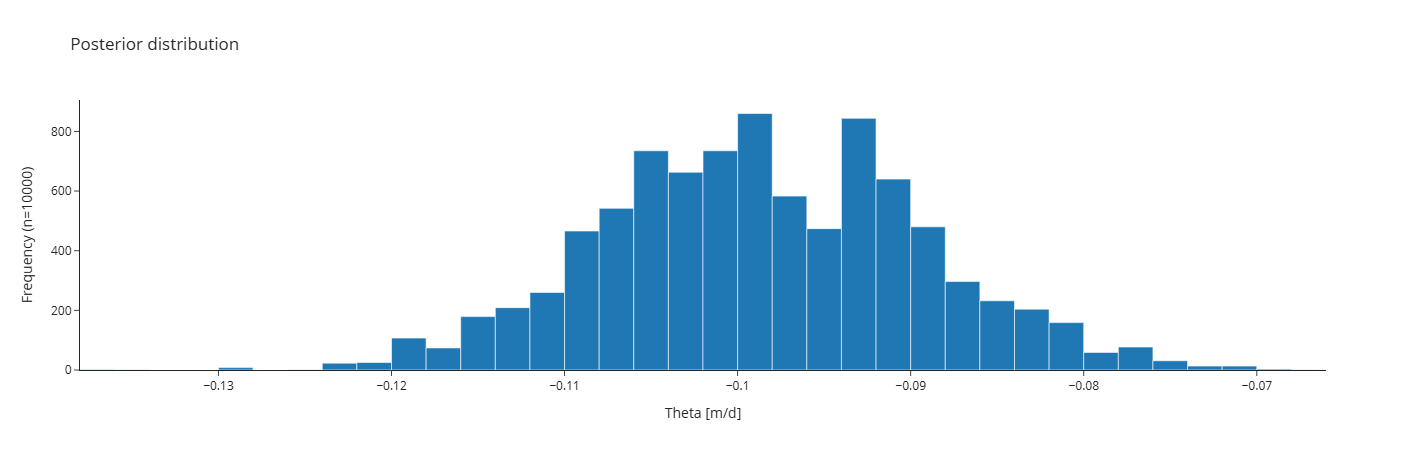

In [48]:
fig = go.Figure(data=[go.Histogram(x=samples[burn_in:, 1], nbinsx=50)])
fig.update_layout(
    title="Posterior distribution",
    xaxis_title="Theta [m/d]",
    yaxis_title=f"Frequency (n={len(samples[:, 0])})",
    template="simple_white",
    width=550,
    height=450
)
fig.show()

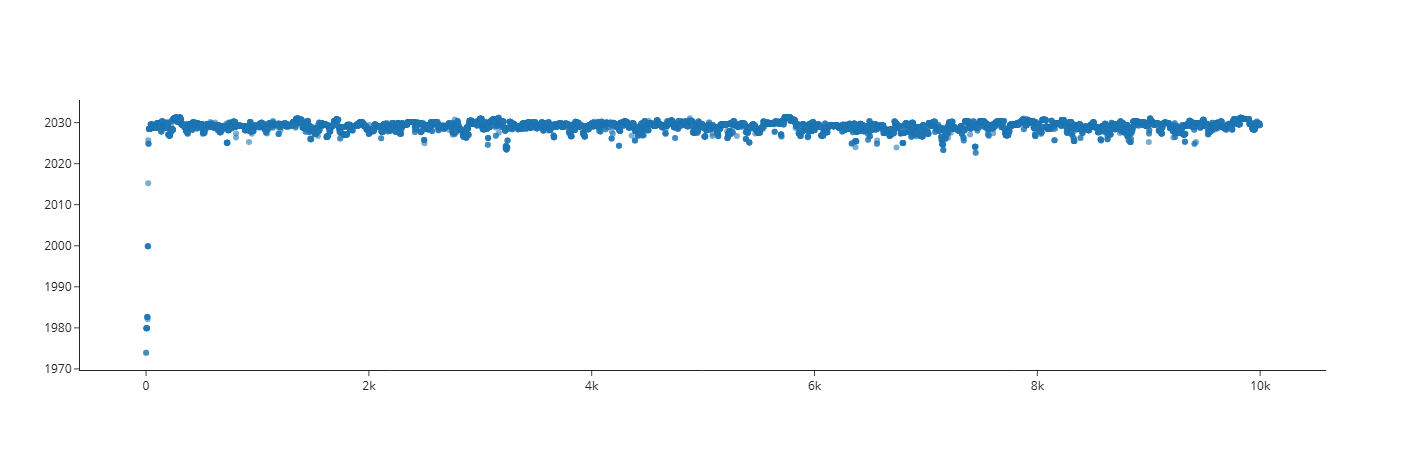

In [43]:
fig = go.Figure(data=go.Scatter(
    x=np.arange(0,len(log_likelihoods)-1),
    y=log_likelihoods,
    mode='markers',
    marker=dict(size=6, opacity=0.6),
))
fig.update_layout(
    # title="EPANET vs GP",
    # xaxis_title="EPANET simulator [mg/L]",
    # yaxis_title="GP surrogate [mg/L]",
    template="simple_white",
    width=550,
    height=450
)
fig.show()